In [19]:
import os
import sys
import math
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity='all'
warnings.filterwarnings('ignore')
%matplotlib inline

In [20]:
# 加载数据集
df = pd.read_csv('user_balance_table.csv')
df.head()

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,20140805,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,20140808,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,20140811,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,20140814,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,20140817,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN


In [21]:
# 转换日期格式，并只保留感兴趣的字段
df['report_date'] = pd.to_datetime(df['report_date'], format='%Y%m%d')
df = df[['report_date', 'total_purchase_amt', 'total_redeem_amt']]
df.head()

,report_date,total_purchase_amt,total_redeem_amt
0,2014-08-05,2,0
1,2014-08-08,2,0
2,2014-08-11,2,0
3,2014-08-14,2,0
4,2014-08-17,2,0


In [22]:
# 按天（D）进行重采样
df.index = df['report_date']
df = df.resample('D').sum()
df.head()

,total_purchase_amt,total_redeem_amt
report_date,,
2013-07-01,32488348,5525022
2013-07-02,29037390,2554548
2013-07-03,27270770,5953867
2013-07-04,18321185,6410729
2013-07-05,11648749,2763587


In [23]:
# 还原report_date列
df['report_date'] = df.index
df.head()

,total_purchase_amt,total_redeem_amt,report_date
report_date,,,
2013-07-01,32488348,5525022,2013-07-01
2013-07-02,29037390,2554548,2013-07-02
2013-07-03,27270770,5953867,2013-07-03
2013-07-04,18321185,6410729,2013-07-04
2013-07-05,11648749,2763587,2013-07-05


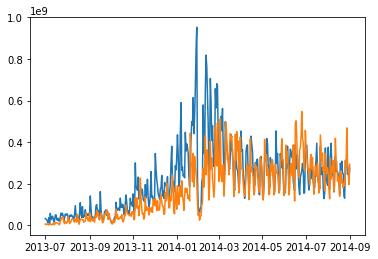

In [24]:
plt.plot(df['total_purchase_amt'])
plt.plot(df['total_redeem_amt'])

In [25]:
def add_timestamp(df):
    df['day'] = df['report_date'].dt.day
    df['month'] = df['report_date'].dt.month
    df['year'] = df['report_date'].dt.year
    df['week'] = df['report_date'].dt.week  # 一年中的第几周
    df['weekday'] = df['report_date'].dt.weekday  # 周几
    return df

In [26]:
# 添加日期信息，并删除2014-03-01前不稳定的数据
df = add_timestamp(df)
df = df[df['report_date'] >= '2014-03-01']
df_copy = df.copy()
df_copy.head()

,total_purchase_amt,total_redeem_amt,report_date,day,month,year,week,weekday
report_date,,,,,,,,
2014-03-01,362865580,211279011,2014-03-01,1,3,2014,9,5
2014-03-02,276202230,246199417,2014-03-02,2,3,2014,9,6
2014-03-03,505305862,513017360,2014-03-03,3,3,2014,10,0
2014-03-04,524146340,250562978,2014-03-04,4,3,2014,10,1
2014-03-05,454295491,209072753,2014-03-05,5,3,2014,10,2


In [27]:
# 计算周一到周日的周期因子：先获得星期几的均值，再除以整体均值
weekday_factor = df[['weekday', 'total_purchase_amt', 'total_redeem_amt']].groupby('weekday', as_index=False).mean()
weekday_factor['total_purchase_amt'] /= np.mean(df['total_purchase_amt'])
weekday_factor['total_redeem_amt'] /= np.mean(df['total_redeem_amt'])
weekday_factor.columns = ['weekday', 'purchase_weekday_factor', 'redeem_weekday_factor']
weekday_factor

,weekday,purchase_weekday_factor,redeem_weekday_factor
0,0,1.185411,1.257964
1,1,1.209608,1.172248
2,2,1.163752,1.157944
3,3,1.139503,1.026762
4,4,0.902682,0.975445
5,5,0.709237,0.669791
6,6,0.712065,0.761712


In [28]:
# 统计（day，weekday）出现的次数
weekday_count = df[['report_date', 'day', 'weekday']].groupby(['day', 'weekday'], as_index=False).count()
weekday_count.rename(columns={'report_date': 'count'}, inplace=True)
weekday_count = pd.merge(weekday_count, weekday_factor, how='left', on='weekday')
weekday_count

,day,weekday,count,purchase_weekday_factor,redeem_weekday_factor
0,1,1,2,1.209608,1.172248
1,1,3,1,1.139503,1.026762
2,1,4,1,0.902682,0.975445
3,1,5,1,0.709237,0.669791
4,1,6,1,0.712065,0.761712
...,...,...,...,...,...
149,30,6,1,0.712065,0.761712
150,31,0,1,1.185411,1.257964
151,31,3,1,1.139503,1.026762
152,31,5,1,0.709237,0.669791


In [29]:
# 计算完周期因子后，下面开始计算日期因子
# 日期因子 = sum (周期因子 * （周一到周日在1~31号出现的频次）/ 一共有几个月份)
# 计算周一到周日的周期因子：先获得星期几的均值，再除以整体均值
n_month = len(np.unique(df['month']))
weekday_count['purchase_day_factor'] = weekday_count['purchase_weekday_factor'] * weekday_count['count'] / n_month
weekday_count['redeem_day_factor'] = weekday_count['redeem_weekday_factor'] * weekday_count['count'] / n_month
day_factor = weekday_count[['day', 'purchase_day_factor', 'redeem_day_factor']].groupby('day', as_index=False).sum()
day_factor

,day,purchase_day_factor,redeem_day_factor
0,1,0.980451,0.963034
1,2,0.972816,0.996800
2,3,1.015888,0.985873
3,4,1.012700,1.050126
4,5,1.019458,0.992417
5,6,0.973279,0.975970
6,7,1.047666,1.057645
7,8,0.980451,0.963034
8,9,0.972816,0.996800
9,10,1.015888,0.985873


In [30]:
# 计算日期平均值
day_mean = df[['day', 'total_purchase_amt', 'total_redeem_amt']].groupby('day', as_index=False).mean()
day_mean

,day,total_purchase_amt,total_redeem_amt
0,1,3.253391e+08,2.347676e+08
1,2,2.481255e+08,2.186074e+08
2,3,2.994808e+08,2.968247e+08
3,4,3.159802e+08,2.925598e+08
4,5,3.286272e+08,2.552484e+08
5,6,2.998453e+08,2.460958e+08
6,7,2.836725e+08,2.374837e+08
7,8,2.918664e+08,2.475255e+08
8,9,2.856603e+08,2.440269e+08
9,10,3.446347e+08,2.593854e+08


In [31]:
# 给day_mean添加日期信息
day_mean['report_date'] = pd.date_range(start='2014-09-01', end='2014-10-01')
day_mean['weekday'] = day_mean['report_date'].dt.weekday
day_mean

,day,total_purchase_amt,total_redeem_amt,report_date,weekday
0,1,3.253391e+08,2.347676e+08,2014-09-01,0
1,2,2.481255e+08,2.186074e+08,2014-09-02,1
2,3,2.994808e+08,2.968247e+08,2014-09-03,2
3,4,3.159802e+08,2.925598e+08,2014-09-04,3
4,5,3.286272e+08,2.552484e+08,2014-09-05,4
5,6,2.998453e+08,2.460958e+08,2014-09-06,5
6,7,2.836725e+08,2.374837e+08,2014-09-07,6
7,8,2.918664e+08,2.475255e+08,2014-09-08,0
8,9,2.856603e+08,2.440269e+08,2014-09-09,1
9,10,3.446347e+08,2.593854e+08,2014-09-10,2


In [32]:
# 将day_mean,周期因子,日期因子这3个表merge起来
day_base = pd.merge(day_mean, day_factor, how='left', on='day')
day_base = pd.merge(day_base, weekday_factor, how='left', on='weekday')
day_base

,day,total_purchase_amt,total_redeem_amt,report_date,weekday,purchase_day_factor,redeem_day_factor,purchase_weekday_factor,redeem_weekday_factor
0,1,3.253391e+08,2.347676e+08,2014-09-01,0,0.980451,0.963034,1.185411,1.257964
1,2,2.481255e+08,2.186074e+08,2014-09-02,1,0.972816,0.996800,1.209608,1.172248
2,3,2.994808e+08,2.968247e+08,2014-09-03,2,1.015888,0.985873,1.163752,1.157944
3,4,3.159802e+08,2.925598e+08,2014-09-04,3,1.012700,1.050126,1.139503,1.026762
4,5,3.286272e+08,2.552484e+08,2014-09-05,4,1.019458,0.992417,0.902682,0.975445
5,6,2.998453e+08,2.460958e+08,2014-09-06,5,0.973279,0.975970,0.709237,0.669791
6,7,2.836725e+08,2.374837e+08,2014-09-07,6,1.047666,1.057645,0.712065,0.761712
7,8,2.918664e+08,2.475255e+08,2014-09-08,0,0.980451,0.963034,1.185411,1.257964
8,9,2.856603e+08,2.440269e+08,2014-09-09,1,0.972816,0.996800,1.209608,1.172248
9,10,3.446347e+08,2.593854e+08,2014-09-10,2,1.015888,0.985873,1.163752,1.157944


In [33]:
# 开始预测
# 某天的预测值 = 当天日期的历史均值 / 当天日期的影响因子 * 当天星期（几）的影响因子
day_pred = day_base.copy()
day_pred['pred_purchase'] = day_pred['total_purchase_amt'] / day_pred['purchase_day_factor'] * day_pred['purchase_weekday_factor']
day_pred['pred_redeem'] = day_pred['total_redeem_amt'] / day_pred['redeem_day_factor'] * day_pred['redeem_weekday_factor']
day_pred

,day,total_purchase_amt,total_redeem_amt,report_date,weekday,purchase_day_factor,redeem_day_factor,purchase_weekday_factor,redeem_weekday_factor,pred_purchase,pred_redeem
0,1,3.253391e+08,2.347676e+08,2014-09-01,0,0.980451,0.963034,1.185411,1.257964,3.933503e+08,3.066653e+08
1,2,2.481255e+08,2.186074e+08,2014-09-02,1,0.972816,0.996800,1.209608,1.172248,3.085214e+08,2.570847e+08
2,3,2.994808e+08,2.968247e+08,2014-09-03,2,1.015888,0.985873,1.163752,1.157944,3.430706e+08,3.486316e+08
3,4,3.159802e+08,2.925598e+08,2014-09-04,3,1.012700,1.050126,1.139503,1.026762,3.555449e+08,2.860506e+08
4,5,3.286272e+08,2.552484e+08,2014-09-05,4,1.019458,0.992417,0.902682,0.975445,2.909838e+08,2.508833e+08
5,6,2.998453e+08,2.460958e+08,2014-09-06,5,0.973279,0.975970,0.709237,0.669791,2.184999e+08,1.688910e+08
6,7,2.836725e+08,2.374837e+08,2014-09-07,6,1.047666,1.057645,0.712065,0.761712,1.928032e+08,1.710349e+08
7,8,2.918664e+08,2.475255e+08,2014-09-08,0,0.980451,0.963034,1.185411,1.257964,3.528802e+08,3.233303e+08
8,9,2.856603e+08,2.440269e+08,2014-09-09,1,0.972816,0.996800,1.209608,1.172248,3.551925e+08,2.869784e+08
9,10,3.446347e+08,2.593854e+08,2014-09-10,2,1.015888,0.985873,1.163752,1.157944,3.947967e+08,3.046577e+08


In [34]:
# 整理数据，输出csv
pred = day_pred[['report_date', 'pred_purchase', 'pred_redeem']]
pred['report_date'] = pred['report_date'].apply(lambda d: str(d).replace('-', '')[:8])
pred = pred[:30]
pred.to_csv('a.csv', index=False, header=False)
print(pred.to_csv(index=False, header=False))

20140901,393350264.8398061,306665306.0977291
20140902,308521434.0454509,257084713.7701202
20140903,343070642.0828501,348631606.4947821
20140904,355544910.4345503,286050621.2905257
20140905,290983812.2230383,250883299.7583486
20140906,218499877.7123456,168891008.92162532
20140907,192803211.74450064,171034893.66521233
20140908,352880161.29074895,323330276.07883084
20140909,355192542.6105618,286978381.8041232
20140910,394796696.45529485,304657702.3605673
20140911,322305463.6895352,298351701.7538888
20140912,243242918.1542801,250482504.64676687
20140913,180706609.67051223,188048160.25717548
20140914,184110830.80142748,212505528.00350782
20140915,357655678.8935367,300712273.7451798
20140916,390940386.68839574,367490535.13398725
20140917,293857734.73291343,350838915.43203884
20140918,315419703.87419015,273671579.844847
20140919,251195564.90060622,256342539.24013594
20140920,212131590.01572716,162497024.02268416
20140921,191342226.93976006,202936038.1412418
20140922,293831973.2076367,34128759

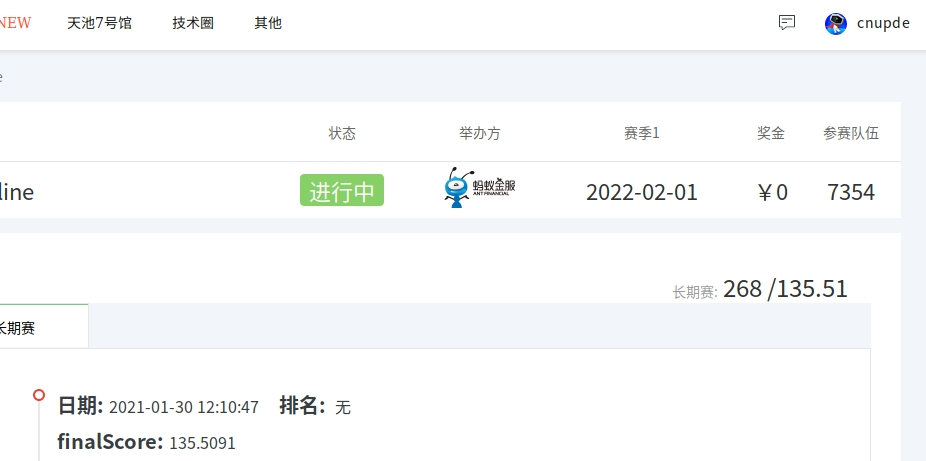

In [35]:
# 结果得分贴图
from IPython.display import Image
Image(filename='result.jpg')